In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt 


In [2]:
# Number of colors to use
num_colors = 6 # max clusters

# Create 6 evenly spaced indices to sample colors from the Viridis colormap
indices = np.linspace(0, 255, num_colors, dtype=int)

# Get colors from the Viridis colormap at the selected indices
viridis_colors = plt.cm.viridis(indices)

Let's start with putting all corresponding to each system together: 

In [3]:
import glob 

wt_yxi1 = glob.glob("./iapp_wt_yxi1bf_centroid_c*.csv")
wt_yxa1 = glob.glob("./iapp_wt_yxa1bf_centroid_c*.csv")
s20g_yxi1 = glob.glob("./iapp_s20g_yxi1bf_centroid_c*.csv")
s20g_yxa1 = glob.glob("./iapp_s20g_yxa1bf_centroid_c*.csv")

In [4]:
wt_yxa1

['./iapp_wt_yxa1bf_centroid_c1.csv',
 './iapp_wt_yxa1bf_centroid_c2.csv',
 './iapp_wt_yxa1bf_centroid_c3.csv',
 './iapp_wt_yxa1bf_centroid_c4.csv',
 './iapp_wt_yxa1bf_centroid_c5.csv']

In [5]:
# List to store the individual DataFrames

df_dict ={}

labels = ["wt_yxi1", "wt_yxa1", "s20g_yxi1", "s20g_yxa1"]
for l, csv_list in enumerate([wt_yxi1, wt_yxa1, s20g_yxi1, s20g_yxa1]):
    dfs = []
    # Read each CSV file, add file number column, and append to dfs list
    for i, file_path in enumerate(csv_list, start=1):
        df = pd.read_csv(file_path)
        df['file_number'] = i
        dfs.append(df)

    # Concatenate the DataFrames
    combined_df = pd.concat(dfs, ignore_index=True)
    df_dict[labels[l]] = combined_df 

In [6]:
# Function to compute molecular descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    descriptors = [desc[1](mol) for desc in Descriptors._descList]
    return descriptors

def compute_pca(smiles_list):
    # Compute descriptors for all SMILES strings
    descriptor_list = [compute_descriptors(smiles) for smiles in smiles_list]
    descriptor_df = pd.DataFrame(descriptor_list, columns=[desc[0] for desc in Descriptors._descList])

    # Standardize the descriptors
    scaler = StandardScaler()
    standardized_descriptors = scaler.fit_transform(descriptor_df)

    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(standardized_descriptors)

    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
    pca_df['SMILES'] = smiles_list

    return pca_df

In [7]:
df_dict["wt_yxi1"].head()

,SMILES,log-likelihoodog,file_number
0,Cc1nsc(-c2ccn(-c3ccc(Oc4ccc(N5CCC(=N)NC5)nn4)c...,33.998493,1
1,CCn1c(Nc2ccnc(-c3cncs3)c2)nc2c1COCn1nc(C)nc1S2,31.719145,1
2,Cn1nc(SCc2csc3c(N4CCC4)ncn23)nc1-c1ccc(C(=O)O)nc1,31.048010,1
3,Cc1nn(-c2nc(Cl)nnc2NC2CCC3(CCN(C)C3)O2)cc1-c1n...,29.899040,1
4,CNc1nccc2nc(-c3cn(-c4ncsc4-c4nccs4)c(C)n3)nn12,29.582186,1


In [8]:
# get the top 5 and draw them 
from rdkit.Chem import Draw, Descriptors, Lipinski
from PIL import Image
from io import BytesIO

# Create a list to store descriptor data
descriptor_data = []

# Process the SMILES strings from your dictionary
for key in df_dict.keys():
    sorted_df = df_dict[key].sort_values(by='log-likelihoodog')
    smiles_list = sorted_df.head(3)["SMILES"]
    mols = []
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        mols.append(mol)
        
        # Calculate descriptors
        data = {
            "SMILES": smile,
            "Molecular weight": Descriptors.MolWt(mol),
            "LogP": Descriptors.MolLogP(mol),
            "Number of hydrogen bond donors": Lipinski.NumHDonors(mol),
            "Number of hydrogen bond acceptors": Lipinski.NumHAcceptors(mol),
            "Topological polar surface area (TPSA)": Descriptors.TPSA(mol),
            "Number of rotatable bonds": Descriptors.NumRotatableBonds(mol),
            "Number of rings": Descriptors.RingCount(mol),
            "Number of atoms": mol.GetNumAtoms(),
            "Aromaticity": Descriptors.NumAromaticRings(mol),
            "Fraction Csp3": Descriptors.FractionCSP3(mol),
            "Key": key
        }
        descriptor_data.append(data)
    
    # Draw molecules
    img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(400, 400), legends=[f'Molecule {i+1}' for i in range(len(mols))], returnPNG=False)
    img.save('molecules_grid3_' + key + '.png')

# Create a DataFrame from the descriptor data
descriptor_df = pd.DataFrame(descriptor_data)

In [9]:
descriptor_df

,SMILES,Molecular weight,LogP,Number of hydrogen bond donors,Number of hydrogen bond acceptors,Topological polar surface area (TPSA),Number of rotatable bonds,Number of rings,Number of atoms,Aromaticity,Fraction Csp3,Key
0,c1coc(-c2csc(Nc3nnc(-c4nnc(CN5CCOCC5)s4)s3)n2)c1,433.544,3.34890,1,12,102.09,6,5,28,4,0.312500,wt_yxi1
1,c1nc(Nc2csc(-c3nnc(CN4CCCCC4)s3)n2)nc(N2CCCC2)n1,429.579,3.17630,1,11,95.85,6,5,29,3,0.555556,wt_yxi1
2,CSC1CCN(c2nc(Nc3nccs3)n3nc(-c4ccco4)nc3n2)CC1,414.520,3.31120,1,11,97.27,5,5,28,4,0.352941,wt_yxi1
3,CN1CCC(Cn2ccc(Nc3ncc4c5ccncc5n([C@H]5CC[C@H](C...,444.587,4.62250,1,8,76.69,5,6,33,4,0.520000,wt_yxa1
4,c1cc2c3cnc(Nc4ccc(OCCN5CCCC5)cn4)nc3n(C3CCCC3)...,443.555,4.70780,1,8,80.99,7,6,33,4,0.440000,wt_yxa1
5,c1cc2c3cnc(Nc4ccn(CCCN5CCCC5)n4)nc3n(C3CCCC3)c...,430.560,4.52060,1,8,76.69,7,6,32,4,0.500000,wt_yxa1
6,Cc1nnc(CN2CCN(c3nc(Nc4nccs4)nc4sccc34)CC2)o1,414.520,2.90502,1,11,96.10,5,5,28,4,0.352941,s20g_yxi1
7,Cc1nnc(CN2CCN(c3nc(Nc4nccs4)nc4ccsc34)CC2)o1,414.520,2.90502,1,11,96.10,5,5,28,4,0.352941,s20g_yxi1
8,O=[N+]([O-])c1ccc(-n2cc(CSSc3nnc(NC(=S)S)s3)nn...,443.586,3.59410,2,11,111.66,7,3,26,3,0.083333,s20g_yxi1
9,O=C(O)Cc1cc2nc(-c3ccc(Oc4ccccc4)cc3)nc(N3CCOCC...,447.516,4.61430,1,7,84.78,6,5,32,4,0.208333,s20g_yxa1


In [10]:
def create_descriptor_df(dictionary): 
    # Create a list to store descriptor data
    descriptor_data = []
    smiles_list = dictionary["SMILES"]
    cluster_list = dictionary["file_number"]
    mols = []
    for n, smile in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smile)
        mols.append(mol)
        
        # Calculate descriptors
        data = {
            "SMILES": smile,
            "Molecular weight": Descriptors.MolWt(mol),
            "LogP": Descriptors.MolLogP(mol),
            "Number of hydrogen bond donors": Lipinski.NumHDonors(mol),
            "Number of hydrogen bond acceptors": Lipinski.NumHAcceptors(mol),
            "Topological polar surface area (TPSA)": Descriptors.TPSA(mol),
            "Number of rotatable bonds": Descriptors.NumRotatableBonds(mol),
            "Number of rings": Descriptors.RingCount(mol),
            "Number of atoms": mol.GetNumAtoms(),
            "Aromaticity": Descriptors.NumAromaticRings(mol),
            "Fraction Csp3": Descriptors.FractionCSP3(mol),
            "Key": key,
            "Cluster":cluster_list[n]
        }
        descriptor_data.append(data)

    # Create a DataFrame from the descriptor data
    descriptor_df = pd.DataFrame(descriptor_data)
    return descriptor_df

In [11]:
describe_wt_yxi1 = create_descriptor_df(df_dict["wt_yxi1"])
describe_s20g_yxi1 = create_descriptor_df(df_dict["s20g_yxi1"])
describe_wt_yxa1 = create_descriptor_df(df_dict["wt_yxa1"])
describe_s20g_yxa1 = create_descriptor_df(df_dict["s20g_yxa1"])

In [68]:
describe_wt_yxi1.head()

,SMILES,Molecular weight,LogP,Number of hydrogen bond donors,Number of hydrogen bond acceptors,Topological polar surface area (TPSA),Number of rotatable bonds,Number of rings,Number of atoms,Aromaticity,Fraction Csp3,Key,Cluster
0,Cc1nsc(-c2ccn(-c3ccc(Oc4ccc(N5CCC(=N)NC5)nn4)c...,433.501,3.01599,2,10,117.73,5,5,31,4,0.200000,s20g_yxa1,1
1,CCn1c(Nc2ccnc(-c3cncs3)c2)nc2c1COCn1nc(C)nc1S2,426.531,3.70392,1,11,95.57,4,5,29,4,0.277778,s20g_yxa1,1
2,Cn1nc(SCc2csc3c(N4CCC4)ncn23)nc1-c1ccc(C(=O)O)nc1,427.515,2.78690,1,10,101.44,6,5,29,4,0.277778,s20g_yxa1,1
3,Cc1nn(-c2nc(Cl)nnc2NC2CCC3(CCN(C)C3)O2)cc1-c1n...,432.941,2.76532,1,10,93.88,4,5,29,3,0.500000,s20g_yxa1,1
4,CNc1nccc2nc(-c3cn(-c4ncsc4-c4nccs4)c(C)n3)nn12,395.477,2.90712,1,11,98.71,4,5,27,5,0.125000,s20g_yxa1,1


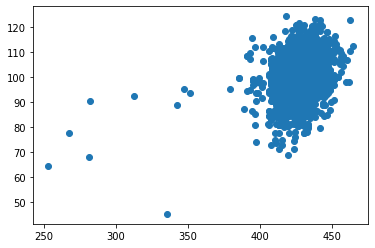

In [13]:
plt.scatter(describe_wt_yxi1["Molecular weight"].to_numpy(), describe_wt_yxi1["Topological polar surface area (TPSA)"].to_numpy())

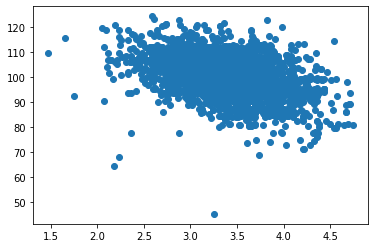

In [14]:
plt.scatter(describe_wt_yxi1["LogP"].to_numpy(), describe_wt_yxi1["Topological polar surface area (TPSA)"].to_numpy())

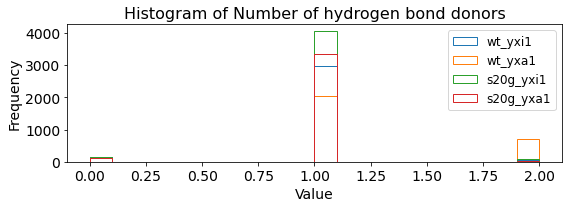

<Figure size 432x288 with 0 Axes>

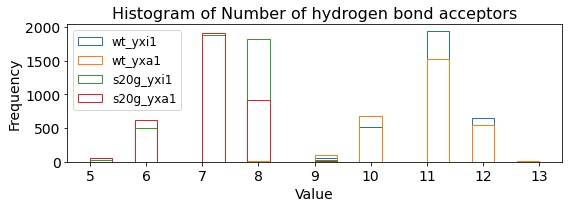

<Figure size 432x288 with 0 Axes>

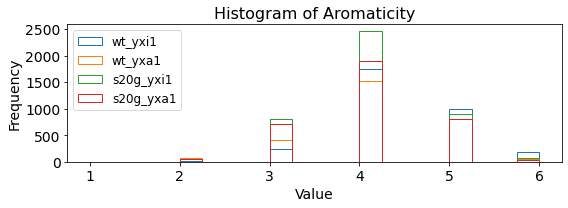

<Figure size 432x288 with 0 Axes>

In [15]:
# let's find the distribution of each of the different hydrogen bond acceptors, donors and aromatics

# Assuming 'column_name' is the column you want to plot
column_names = ["Number of hydrogen bond donors","Number of hydrogen bond acceptors", "Aromaticity"]
datas = [describe_wt_yxi1, describe_s20g_yxi1, describe_wt_yxa1, describe_s20g_yxa1]
ranges = [(0,2),(5,13), (1,6)]

for k,cname in enumerate(column_names):
    # Plotting the histogram
    plt.figure(figsize=(8,3))
    # get histogram for all entries for an ensemble. 
    for l, data in enumerate(datas): 
        plt.hist(data[cname].to_numpy(), bins=20, label=labels[l], histtype="step", range=ranges[k])  # Adjust the number of bins as needed
        plt.xlabel('Value', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
    
    plt.title(f'Histogram of {cname}', fontsize=16)
    plt.legend(fontsize=12)  # Set the font size for the legend
    plt.xticks(fontsize=14)  # Set the font size for x-axis ticks
    plt.yticks(fontsize=14)  # Set the font size for y-axis ticks
    plt.tight_layout()
    plt.savefig(cname+"_hist.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.clf()

Now, we're going to run PCA analyis on all of the smiles strings and add a qsar score, which is a similarity score to the ligands. 

In [17]:
pca_df_wt_iapp_yxi1 = compute_pca(describe_wt_yxi1["SMILES"])

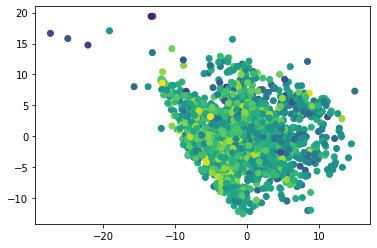

In [18]:
plt.scatter(pca_df_wt_iapp_yxi1["PC1"], pca_df_wt_iapp_yxi1["PC2"], c=describe_wt_yxi1["LogP"])

In [38]:
import os
# Get a list of all CSV files in the directory
csv_files = glob.glob("./qsar/*.csv")
# Load and concatenate all CSV files into a single DataFrame
df_list = []

for file in csv_files:
    temp_df = pd.read_csv(file) 
    temp_df["key"] = os.path.splitext(file)[0][7:-17]
    df_list.append(temp_df)

combined_qsar_df = pd.concat(df_list, ignore_index=True)

In [39]:
combined_qsar_df.head()

,SMILES,cats_euclidean_dist,key
0,O=c1sc2c(ccn2-c2nccs2)cc1-n1cc(/C=N/Nc2nccs2)nn1,9.539392,iapp_s20g_yxi1bf
1,C/C(=N\Nc1nn2nc(-c3ccc(C#N)s3)nc2s1)c1cnc2c(cc...,9.746794,iapp_s20g_yxi1bf
2,C/C(=N\Nc1cccc(-c2nccs2)n1)c1nc2sc(=S)sc2c(=O)n1C,9.949874,iapp_s20g_yxi1bf
3,Cc1cc2c(-c3nnc(-c4nc(O)c5sc6nn(C)cc6c5n4)s3)nn...,10.344080,iapp_s20g_yxi1bf
4,CSc1ccc(-n2ncc3c(O)nc(-c4nc(-c5cccs5)nn4C)nc32)s1,10.344080,iapp_s20g_yxi1bf


In [40]:
pca_df_all = compute_pca(combined_qsar_df["SMILES"])

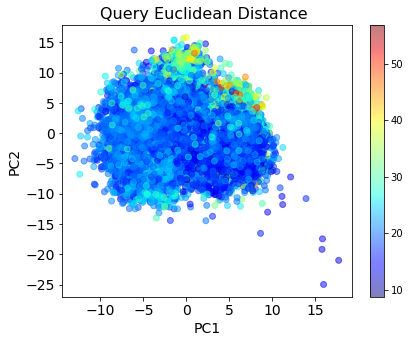

<Figure size 432x288 with 0 Axes>

In [49]:
plt.figure(figsize=(6.5,5))
plt.title("Query Euclidean Distance ", fontsize=16)
plt.scatter(pca_df_all["PC1"], pca_df_all["PC2"], c=combined_qsar_df["cats_euclidean_dist"], cmap="jet", alpha=0.5)
plt.ylabel("PC2", fontsize=14)
plt.xlabel("PC1", fontsize=14)
plt.xticks(fontsize=14)  # Set the font size for x-axis ticks
plt.yticks(fontsize=14)  # Set the font size for y-axis ticks
plt.colorbar()
plt.savefig( "euclidean_distance_all_scatter_plot.png", dpi=300, bbox_inches="tight")
plt.show()
plt.clf()


In [53]:
# let's plot the overlaps between each corresponding ligand
data = {"x": pca_df_all["PC1"].to_numpy(),
        "y": pca_df_all["PC2"].to_numpy(),
        "category": combined_qsar_df["key"].to_numpy()
        }
df = pd.DataFrame(data)

In [59]:
top_ones = descriptor_df["SMILES"].to_numpy()[::3]

# Value to find
for value_to_find in top_ones:
    # Find the index of the first occurrence of the value
    index = combined_qsar_df[combined_qsar_df['SMILES'] == value_to_find].index[0]
    print(f"The index of the entry {value_to_find} in column 'SMILES' is {index}.")

The index of the entry c1coc(-c2csc(Nc3nnc(-c4nnc(CN5CCOCC5)s4)s3)n2)c1 in column 'SMILES' is 12345.
The index of the entry CN1CCC(Cn2ccc(Nc3ncc4c5ccncc5n([C@H]5CC[C@H](C)CC5)c4n3)n2)C1 in column 'SMILES' is 8332.
The index of the entry Cc1nnc(CN2CCN(c3nc(Nc4nccs4)nc4sccc34)CC2)o1 in column 'SMILES' is 5812.
The index of the entry O=C(O)Cc1cc2nc(-c3ccc(Oc4ccccc4)cc3)nc(N3CCOCC3)c2s1 in column 'SMILES' is 11894.


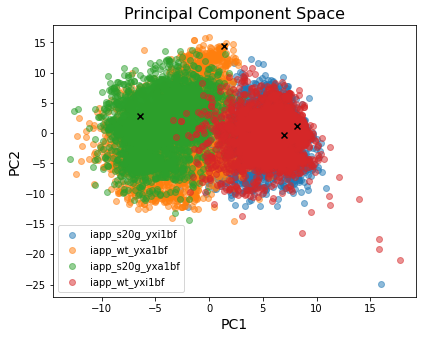

In [66]:
fig, ax = plt.subplots(figsize=(6.5,5))
# Loop through each category and plot the corresponding points
for category in df['category'].unique():
    subset = df[df['category'] == category]
    ax.scatter(subset['x'], subset['y'], label=category, alpha=0.5)
# Add a legend
ax.legend()
# Add labels and title
plt.scatter(df.loc[[12345, 8332, 5812, 11894]]["x"], df.loc[[12345, 8332, 5812, 11894]]["y"], marker="x",color="k")
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_title('Principal Component Space', fontsize=16)
plt.savefig( "PCA_space_all_scatter_plot.png", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()

In [67]:
print(df.loc[[12345, 8332, 5812, 11894]]["x"], df.loc[[12345, 8332, 5812, 11894]]["y"])

12345    6.975385
8332     1.382484
5812     8.223813
11894   -6.442953
Name: x, dtype: float64 12345    -0.244376
8332     14.343907
5812      1.257166
11894     2.832988
Name: y, dtype: float64
